# Import Packages

In [1]:
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

In [2]:
# Transform for data normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST data
training_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)
print("training dataset size: ", len(training_dataset))
print("test dataset size: ", len(test_dataset))

# Concatenate Datasets
dataset = ConcatDataset([training_dataset, test_dataset])
print("total dataset size: ", len(dataset))

# Splitting Dataset
train_dataset, temp_dataset = train_test_split(dataset, test_size=0.4)
val_dataset, test_dataset = train_test_split(temp_dataset, test_size=0.5)
print("training dataset size after splitting:", len(train_dataset))
print("validation dataset size after splitting:", len(val_dataset))
print("testing dataset size after splitting:", len(test_dataset))

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>



100%|██████████| 9.91M/9.91M [01:19<00:00, 125kB/s] 


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 194kB/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>



100%|██████████| 1.65M/1.65M [00:02<00:00, 700kB/s] 


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

training dataset size:  60000
test dataset size:  10000
total dataset size:  70000
training dataset size after splitting: 42000
validation dataset size after splitting: 14000
testing dataset size after splitting: 14000


# General class for our Neural Network Architectures

In [3]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, learning_rate, batch_size):
        super(FeedforwardNN, self).__init__()
        
        # Save learning rate and batch size for later use
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.input_size = input_size
        self.output_size = output_size

        # Create the layers of the neural network
        layers = []
        in_features = input_size
        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())  # Activation function for hidden layers
            in_features = hidden_units
        
        # Output layer
        layers.append(nn.Linear(in_features, output_size))
        
        # Combine layers in a sequential model
        self.model = nn.Sequential(*layers)
        
        # Loss function and optimizer
        self.criterion = nn.CrossEntropyLoss()  # or nn.MSELoss() for regression
        self.optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)
    
    def forward(self, x):
        return self.model(x)
    
    def train_model(self, train_dataset, val_dataset, epochs=10):
        # Prepare dataloaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size)
        
        # Lists to store loss values for each epoch
        train_losses = []
        val_losses = []
        
        for epoch in range(epochs):
            # Training phase
            self.train()  # Set the model to training mode
            running_train_loss = 0.0
            for images, labels in train_loader:
                images = images.reshape(-1, self.input_size)

                # Forward pass
                outputs = self.forward(images)
                loss = self.criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                running_train_loss += loss.item()
            
            # Calculate average training loss for the epoch
            epoch_train_loss = running_train_loss / len(train_loader)
            train_losses.append(epoch_train_loss)
            
            # Validation phase
            self.eval()  # Set the model to evaluation mode
            running_val_loss = 0.0
            with torch.no_grad():  # Disable gradient computation
                for images, labels in val_loader:
                    images = images.reshape(-1, self.input_size)
                    
                    # Forward pass
                    outputs = self.forward(images)
                    loss = self.criterion(outputs, labels)
                    
                    running_val_loss += loss.item()
            
            # Calculate average validation loss for the epoch
            epoch_val_loss = running_val_loss / len(val_loader)
            val_losses.append(epoch_val_loss)
            
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
            
        # Plotting the training and validation losses
        plt.plot(range(1, epochs + 1), train_losses, marker='o', color='b', label='Training Loss')
        plt.plot(range(1, epochs + 1), val_losses, marker='o', color='r', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.show()

    def test_model(self, test_dataset):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        n_correct = 0
        n_samples = len(test_loader.dataset)
        
        # Collect all predictions and true labels
        all_preds = []
        all_labels = []
        
        for images, labels in test_loader:
            images = images.reshape(-1, self.input_size)

            # Forward pass
            outputs = self.forward(images)

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            n_correct += (predicted == labels).sum().item()

            # Store predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Calculate accuracy
        acc = n_correct / n_samples
        print(f'Accuracy of the network on the {n_samples} test images: {100 * acc:.2f} %')

        # Compute confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    

# Model Training and Validation

Epoch [1/10], Train Loss: 0.9062, Val Loss: 0.4858
Epoch [2/10], Train Loss: 0.4065, Val Loss: 0.3697
Epoch [3/10], Train Loss: 0.3499, Val Loss: 0.3377
Epoch [4/10], Train Loss: 0.3224, Val Loss: 0.3149
Epoch [5/10], Train Loss: 0.3043, Val Loss: 0.3079
Epoch [6/10], Train Loss: 0.2895, Val Loss: 0.2869
Epoch [7/10], Train Loss: 0.2764, Val Loss: 0.2842
Epoch [8/10], Train Loss: 0.2640, Val Loss: 0.2684
Epoch [9/10], Train Loss: 0.2523, Val Loss: 0.2787
Epoch [10/10], Train Loss: 0.2419, Val Loss: 0.2548


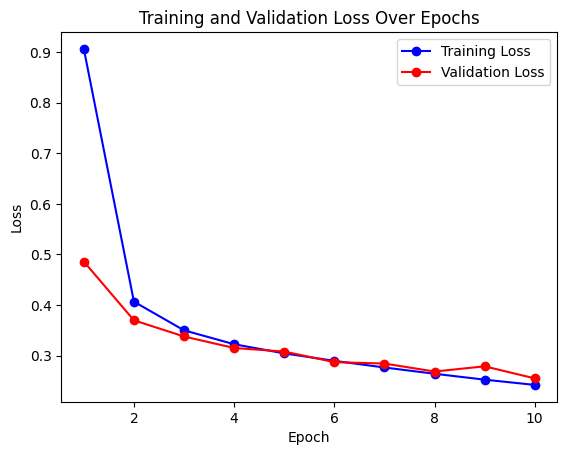

In [4]:
# fixed parameters
input_size = 28*28      # size of image
output_size = 10        # number of digits

# hyperparameters
hidden_layers = 1
hidden_units = 60
learning_rate = 0.01
batch_size = 64

model1 = FeedforwardNN(input_size, output_size, hidden_layers, hidden_units, learning_rate, batch_size)
model1.train_model(train_dataset, val_dataset)

#  Model Testing

Accuracy of the network on the 14000 test images: 92.49 %


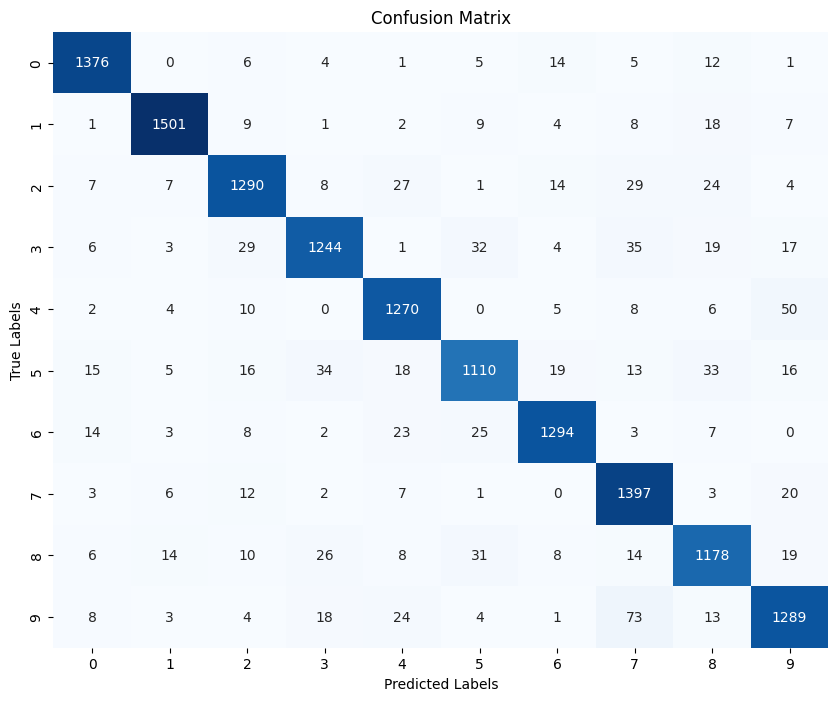

In [5]:
model1.test_model(test_dataset)